# Parte 2: Face Detection
### Santiago Juani & Florencia Migues

## Imports

In [1]:
%load_ext tensorboard

In [2]:
import cv2 
import numpy as np
from glob import glob
from enum import Enum
import os
import sklearn
from skimage.feature import hog
from sklearn import svm
import sklearn.neighbors
import matplotlib.pyplot as plt
from evaluation import evaluate_detector, precision_and_recall, interpolated_average_precision
import sys
from image_utils import non_max_suppression
from tqdm import tqdm
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
import datetime
import shutil

In [3]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

## Feature Estractors
#### Implementacion: Hog

In [4]:
class FeatureExtractors(Enum):
    MiniImage = 1
    HOG = 2
    LBP = 3
    CNN = 4

def extract_features(method, image):
	'''Switch between Feature extraction Methods'''

	image_representation = []

	if method == FeatureExtractors.MiniImage:
		image_representation = extract_mini_image_features(image)
	elif method == FeatureExtractors.HOG:
		image_representation = extract_hog_features(image)
	elif method == FeatureExtractors.LBP:
		image_representation = extract_lbp_features(image)
	elif method == FeatureExtractors.CNN:
		image_representation = prep_for_cnn(image)
	
	return image_representation

def extract_mini_image_features(image,resize_size=(64,64)):
    shape = image.shape
    if len(shape) > 2:
        image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    resized_image = cv2.resize(image,resize_size)
    image_representation = resized_image.reshape(resize_size[0]*resize_size[1])
    return image_representation
  
def extract_lbp_features(img):
    return []

def extract_hog_features(img):
    #img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    fd = hog(img, orientations=8, pixels_per_cell=(16, 16),
                      cells_per_block=(1, 1), visualize=False)
    return fd

def prep_for_cnn(img):
    #print(img.shape)
    if len(img.shape)==3 and img.shape[2] == 3:
        img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    return img/255.0

## Data Loader & ShowImg

In [5]:
def load_training_data(training_positive_dir,trainign_negative_dir,feature_extractor=FeatureExtractors.HOG,target_size=[128,128]):
    ''' Function for loading loading training data from positive and negative examples
    '''
    positive_img_files = sorted(glob(training_positive_dir + '/*'))
    negative_img_files = sorted(glob(trainign_negative_dir + '/*'))
    #positive_img_files = positive_img_files[:5000]
    #negative_img_files = negative_img_files[:5000]
    training_data = []
    training_labels = []
    
    print('##Loading {} positive face images'.format(len(positive_img_files)))
    for img in tqdm(positive_img_files, total=len(positive_img_files)):
        image = cv2.imread(img)[...,::-1]
        image = cv2.resize(image, target_size, cv2.INTER_AREA)
        image_representation = extract_features(feature_extractor,image)
        training_data.append(image_representation)
        training_labels.append(1)
    
    print('##Loading {} negative face images'.format(len(negative_img_files)))
    for img in tqdm(negative_img_files,total=len(negative_img_files)):
        image = cv2.imread(img)[...,::-1]
        image = cv2.resize(image, target_size, cv2.INTER_AREA)
        image_representation = extract_features(feature_extractor,image)
        training_data.append(image_representation)
        training_labels.append(0)   
    
    training_data = np.asarray(training_data)
    training_labels = np.asarray(training_labels)
    return training_data, training_labels

def load_validation_data(validation_data_dir):

    validation_image_files = sorted(glob(validation_data_dir + '/*.jpg'))
    val_images = []
    
    validation_annotations= pd.read_csv(os.path.join(validation_data_dir,'validation_bbox.csv'))
    
    print(validation_annotations.shape)
    validation_bboxes = []
    for img_file in tqdm(validation_image_files,total=len(validation_image_files)):
        image = cv2.imread(img_file,cv2.IMREAD_COLOR)
        val_images.append(image)
        image_name = os.path.basename(img_file)
        bbox_info = validation_annotations.loc[validation_annotations["image_id"]==image_name]
        bbox = np.array([bbox_info['x_left'].values[0],bbox_info['y_top'].values[0],bbox_info['x_left'].values[0]+bbox_info['width'].values[0],bbox_info['y_top'].values[0]+bbox_info['height'].values[0]])
        validation_bboxes.append(bbox)
        
    return val_images, validation_bboxes

def show_image_with_bbox(image,bboxes,gt_bbox,draw_GT=True):
    if draw_GT: 
        cv2.rectangle(image, (gt_bbox[0],gt_bbox[1]), (gt_bbox[2],gt_bbox[3]), (0, 0, 255), 2)

    for bbox in bboxes:
        if len(bbox) == 4:   
            top_left = (int(bbox[0]),int(bbox[1]))
            bottom_right = (int(bbox[0])+ int(bbox[2]),int(bbox[1])+int(bbox[3]))
            cv2.rectangle(image, top_left, bottom_right, (255, 0, 0), 2)

    plt.imshow(image[...,::-1])
    plt.axis('off')
    plt.show()

## Sliding Window
Implementacion propia

In [6]:
def total_windows(img, window_size, step_size):
    [i_rows, i_cols] = img.shape;
    w_rows = window_size[1];
    w_cols = window_size[0];
    
    cc = (i_cols+ step_size - w_cols)/step_size
    cr = (i_rows+ step_size - w_rows)/step_size
    return int(cc*cr)

def sliding_window(img, window_size, scale, step_size):
    
    scales = [scale]#, 3*(scale/4), scale/2, 2*scale/3, scale/3]
    images = []
    
    ct = 0
    
    for s in scales:
        width = int(img.shape[1]*s)
        heigh = int(img.shape[0]*s)
        
        image = cv2.resize(img, (width, heigh),
                           interpolation = cv2.INTER_AREA)
        
        if (image.shape[0] < window_size[0] or image.shape[1] < window_size[1]):
            break
        
        images.append(image)
        ct += total_windows(image, window_size, step_size)
       
    patches = np.zeros((window_size[0], window_size[1], 250))
    bbox_locations = np.zeros((250, 4))

    i=0
    err = 0
    for image in images:
        #print(image.shape)
        for y in range(0, image.shape[0], step_size):
            for x in range(0, image.shape[1], step_size):
                try:
                    patches[:,:,i] = image[y:y+window_size[0], x:x+window_size[1]]
                    bbox_locations[i,:] = [int(x*(float(img.shape[1])/float(image.shape[1]))), 
                                           int(y*(float(img.shape[0])/float(image.shape[0]))),
                                           int(window_size[0]*(float(img.shape[0])/float(image.shape[0]))),
                                           int(window_size[1]*(float(img.shape[1])/float(image.shape[1])))]
                    i+= 1
                except:
                    if i >= ct:
                        err += 1
    print('i: ', i, 't: ', ct, 'err: ', err)
    return patches, bbox_locations

## Test Sliding Window

 51%|█████▏    | 90/175 [00:00<00:00, 449.59it/s]

(175, 6)


100%|██████████| 175/175 [00:00<00:00, 456.50it/s]


i:  875 t:  875 err:  1


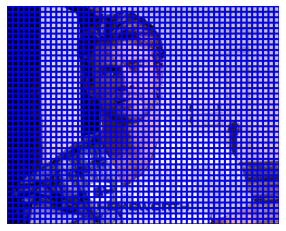

In [14]:
data_dir='./'
face_detection_dir = os.path.join(data_dir, 'face_detection')
validation_raw_faces_dir = os.path.join(face_detection_dir,'val_raw_images')

val_data, val_bboxes = load_validation_data(validation_faces_dir)

image = val_data[100]
gray_image = extract_features(FeatureExtractors.CNN, image)

window_size = (128, 128)
stride = 8

patches, bbox_locations = [], []
patches, bbox_locations = sliding_window(gray_image, window_size, 1, stride)
show_image_with_bbox(image, bbox_locations,
                     [0, 0, window_size[0], window_size[1]],
                     draw_GT=True)

# Entrenamiento del Modelo

## Carga de datos de entrenamiento

#### Ubicacion de los datos

In [7]:
data_dir='./'
face_detection_dir = os.path.join(data_dir, 'face_detection')
training_faces_dir = os.path.join(face_detection_dir,'cropped_faces')
negative_examples_training_dir = os.path.join(face_detection_dir,'negative_data')
validation_faces_dir = os.path.join(face_detection_dir,'validation')
validation_raw_faces_dir = os.path.join(face_detection_dir,'val_raw_images')

#### Load Training Data

In [8]:
training_data, training_labels = load_training_data(training_faces_dir,
                                                   negative_examples_training_dir,
                                                   FeatureExtractors.CNN)

  1%|          | 109/9914 [00:00<00:18, 542.25it/s]

##Loading 9914 positive face images


  2%|▏         | 117/7489 [00:00<00:12, 586.75it/s]

##Loading 7489 negative face images


100%|██████████| 7489/7489 [00:13<00:00, 547.44it/s]


#### Load Validation Data

In [9]:
validation_data = load_validation_data(validation_faces_dir)

 21%|██        | 37/175 [00:00<00:00, 369.67it/s]

(175, 6)


100%|██████████| 175/175 [00:00<00:00, 399.18it/s]


#### Entrenar el clasificador SVM de sklearn

In [ ]:
svm_classifier = svm.SVC(kernel='linear',
                         probability=True)

In [ ]:
svm_classifier.fit(training_data, training_labels)

## Keras CNN

In [25]:
model = Sequential()


model.add(Conv2D(32, (3,3), input_shape=(128, 128, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (3,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (3,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))

model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

optimizer = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='binary_crossentropy',
             optimizer='rmsprop',
             metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 126, 126, 32)      320       
                                                                 
 batch_normalization_6 (Batc  (None, 126, 126, 32)     128       
 hNormalization)                                                 
                                                                 
 activation_8 (Activation)   (None, 126, 126, 32)      0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 61, 61, 32)        9248      
                                                                 
 batch_normalization_7 (Batc  (None, 61, 61, 32)      

## Model Training

In [24]:
%tensorboard --logdir ./logs/ --host localhost

Reusing TensorBoard on port 6006 (pid 268), started 1:44:54 ago. (Use '!kill 268' to kill it.)

In [12]:
if not os.path.exists('./checkpoints'):
    os.makedirs('./checkpoints')
check_point_model = os.path.join('./checkpoints','checkpoint_model_more_LR.hdf5')

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(training_data,
                                                    training_labels,
                                                    test_size=0.33,
                                                    random_state=7)

if os.path.exists('./logs'):
    shutil.rmtree('./logs')
checkpoint = ModelCheckpoint(check_point_model,
                            monitor='val_loss',
                            verbose=1,
                            save_best_only=True,
                            mode='min')

history = model.fit(x_train, y_train,
                    epochs=200,
                    batch_size=32,
                    validation_data=(x_test, y_test),
                    callbacks=[checkpoint, TensorBoard(f'./logs/model_more_LR')])

Epoch 1/200
365/365 [==============================] - ETA: 0s - loss: 0.2768 - accuracy: 0.9065
Epoch 1: val_loss improved from inf to 2.09114, saving model to ./checkpoints\checkpoint_model.hdf5
365/365 [==============================] - 104s 282ms/step - loss: 0.2768 - accuracy: 0.9065 - val_loss: 2.0911 - val_accuracy: 0.4381
Epoch 2/200
365/365 [==============================] - ETA: 0s - loss: 0.1273 - accuracy: 0.9694
Epoch 2: val_loss improved from 2.09114 to 0.09961, saving model to ./checkpoints\checkpoint_model.hdf5
365/365 [==============================] - 102s 280ms/step - loss: 0.1273 - accuracy: 0.9694 - val_loss: 0.0996 - val_accuracy: 0.9709
Epoch 3/200
365/365 [==============================] - ETA: 0s - loss: 0.1009 - accuracy: 0.9750
Epoch 3: val_loss did not improve from 0.09961
365/365 [==============================] - 103s 281ms/step - loss: 0.1009 - accuracy: 0.9750 - val_loss: 0.1028 - val_accuracy: 0.9671
Epoch 4/200
365/365 [==============================] 

In [16]:
model.load_weights(os.path.join('./checkpoints','checkpoint_model.hdf5'))

test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)
print('test_acc', test_acc)
print('test_loss', test_loss)

180/180 - 13s - loss: 0.0469 - accuracy: 0.9861 - 13s/epoch - 75ms/step
test_acc 0.9860699772834778
test_loss 0.04690321162343025


#### Save trained model

In [ ]:
#svm
pickle.dump(svm_classifier, open('./face_detector', 'wb'))

In [17]:
#cnn
model.save('face_detector.h5')

#### Load trained model

In [ ]:
# svm
classifier = pickle.load(open('./face_detector','rb'))

In [18]:
#cnn
classifier = keras.models.load_model('face_detector.h5')

In [ ]:
## RELOAD MODEL
model = keras.models.load_model('face_detector_034.h5')
#model.summary()

## Sliding Window & Results

 22%|██▏       | 39/175 [00:00<00:00, 389.64it/s]

(175, 6)


100%|██████████| 175/175 [00:00<00:00, 422.32it/s]


i:  250 t:  866 err:  0
8/8 [==============================] - 1s 59ms/step


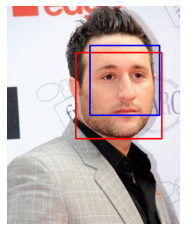

i:  250 t:  643 err:  0
8/8 [==============================] - 1s 65ms/step


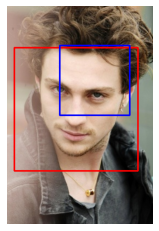

i:  250 t:  1150 err:  0
8/8 [==============================] - 1s 67ms/step


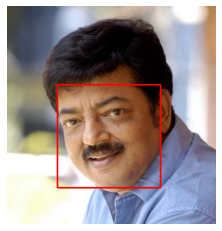

i:  228 t:  226 err:  559
8/8 [==============================] - 1s 72ms/step


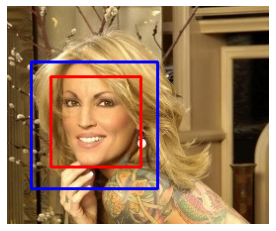

i:  250 t:  1163 err:  0
8/8 [==============================] - 1s 63ms/step


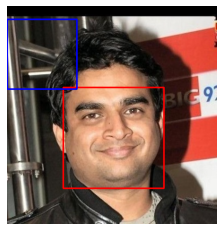

i:  250 t:  691 err:  0
8/8 [==============================] - 1s 64ms/step


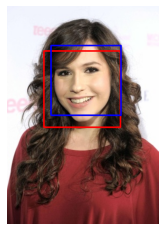

i:  250 t:  787 err:  0
8/8 [==============================] - 1s 64ms/step


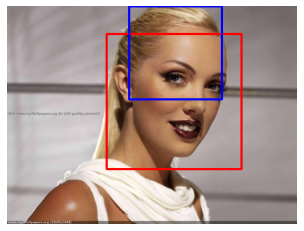

i:  250 t:  660 err:  0
8/8 [==============================] - 1s 64ms/step


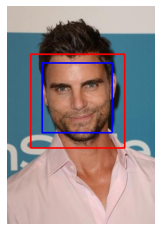

i:  250 t:  643 err:  0
8/8 [==============================] - 1s 61ms/step


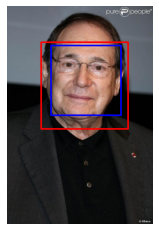

i:  250 t:  761 err:  0
8/8 [==============================] - 1s 63ms/step


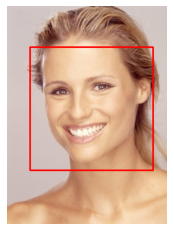

In [81]:
'''
Afinar parametros:
    threshold_p
    overlap_threshold
    non_max_threshold
'''

non_max_threshold = 0.8
window_size = (128, 128)
scale = 1
predictions = []
threshold_p = 0.5
overlap_threshold = 0.5
validation_data, validation_bboxes = load_validation_data(validation_faces_dir)
sample_images = 10
stride = 8
for img, gt_bbox in zip(validation_data[:sample_images],validation_bboxes[:sample_images]):
    gray_image = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    patches, bbox_locations = sliding_window(gray_image,window_size,scale,stride)
    
    ## You need to extract features for every patch (same features you used for training the classifier)
    patches_feature_representation = []
    for i in range(patches.shape[2]):
        patch_representation = extract_features(FeatureExtractors.CNN, patches[:,:,i])
        patches_feature_representation.append(patch_representation)
    patches_feature_representation = np.asarray(patches_feature_representation)
    
    ## Get prediction label for each sliding window patch
    if patches_feature_representation.shape[0] > 0:
        scores = classifier.predict(patches_feature_representation)
        face_probabilities = scores[:,0]
        face_bboxes = bbox_locations[face_probabilities>threshold_p]
        face_bboxes_probabilites = face_probabilities[face_probabilities>threshold_p]
        
        # Do non max suppression and select strongest probability box
        [selected_bbox, selected_score] = non_max_suppression(face_bboxes,face_bboxes_probabilites,0.3)
    else:
        selected_bbox = []
    show_image_with_bbox(img, selected_bbox,gt_bbox)

## Evaluate Detector

In [19]:
total_true_positives = []
total_real_positives = []
total_positive_predictions = []
window_size = [128, 128]
validation_data, validation_bboxes = load_validation_data(validation_faces_dir)
k = 0
stride = 8
scale = 1
for img, gt_bbox in zip(validation_data,validation_bboxes):
    gray_image = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    patches, bbox_locations = sliding_window(gray_image,window_size,scale,stride)
    ## You need to extract features for every patch (same features you used for training the classifier)
    patches_feature_representation = []
    for i in range(patches.shape[2]):
        patch_representation = extract_features(FeatureExtractors.CNN, patches[:,:,i])
        patches_feature_representation.append(patch_representation)
    patches_feature_representation = np.asarray(patches_feature_representation)
    ## Get score for each sliding window patch
    scores = classifier.predict(patches_feature_representation)  
    #print(scores)
    ## Positive Face Probabilities
    face_probabilities = scores[:,0]
    ## liblinbear prediction
    #[labels, acc, prob] = predict([],patches_feature_representation, clasifier)
    #face_probabilities = np.asarray(prob)
    #face_probabilities = face_probabilities.T[0]

    [ detected_true_positives, image_real_positives, detected_faces ] = evaluate_detector( bbox_locations, face_probabilities);
    total_true_positives.append(detected_true_positives)
    total_real_positives.append(image_real_positives)
    total_positive_predictions.append(detected_faces)
        
total_true_positives = np.asarray(total_true_positives)
total_real_positives = np.asarray(total_real_positives)
total_positive_predictions = np.asarray(total_positive_predictions)

 37%|███▋      | 64/175 [00:00<00:00, 316.73it/s]

(175, 6)


100%|██████████| 175/175 [00:00<00:00, 321.14it/s]


i:  250 t:  866 err:  0
8/8 [==============================] - 1s 76ms/step
i:  250 t:  643 err:  0
8/8 [==============================] - 1s 78ms/step
i:  250 t:  1150 err:  0
8/8 [==============================] - 1s 78ms/step
i:  228 t:  226 err:  559
8/8 [==============================] - 1s 76ms/step
i:  250 t:  1163 err:  0
8/8 [==============================] - 1s 75ms/step
i:  250 t:  691 err:  0
8/8 [==============================] - 1s 74ms/step
i:  250 t:  787 err:  0
8/8 [==============================] - 1s 76ms/step
i:  250 t:  660 err:  0
8/8 [==============================] - 1s 73ms/step
i:  250 t:  643 err:  0
8/8 [==============================] - 1s 73ms/step
i:  250 t:  761 err:  0
8/8 [==============================] - 1s 76ms/step
i:  250 t:  875 err:  0
8/8 [==============================] - 1s 73ms/step
i:  250 t:  651 err:  0
8/8 [==============================] - 1s 77ms/step
i:  250 t:  1032 err:  0
8/8 [==============================] - 1s 77ms/step
i:  250

In [20]:
precision, recall = precision_and_recall(total_true_positives, total_real_positives,total_positive_predictions)

(0.0, 1.1)

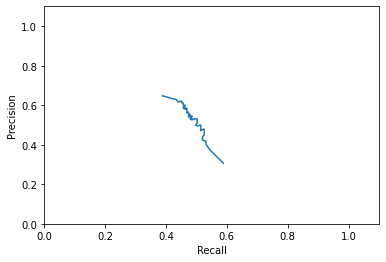

In [21]:
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim(0,1.1)
plt.ylim(0,1.1)

In [22]:
ap = interpolated_average_precision(recall,precision)
print('Detection Average Precision is {}'.format(ap))

Detection Average Precision is [0.25164626]


### Implementacion CNN:
TOP SCORE